   # Prepare Labels and Features Datasets

  - Get SMILES for all compounds 
  - Remove rows with NaN / None SMILE values 
  - get TPSA for remaining compounds
  - add Ln(TPSA) and Log(TPSA)
  - 
**Input Files**
  -   `/input/compound.csv  OR ./output/cp_compound_metadata.csv`

**Intermediate Files**
  -   

**Output Files**
  - `compound_pharmacophores_sparse_clean.pkl`  File of compound pharmacophores in sparse format


# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [246]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from operator import mod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# from KevinsRoutines.utils.utils_general  import  list_namespace 

from itertools import repeat
import more_itertools
from multiprocessing import Pool, process
from os import getpid
from rdkit.Chem import PandasTools

pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=10, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 180

['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [71]:

from KevinsRoutines.utils.utils_chem import (getSmilesFromRDKit, getTPSAFromRDKit)

In [43]:
from utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = './output_10162024/')
display_project_datasets(ds)

 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ./output_10162024/

 Input Datasets : 
 ---------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ./output_10162024/compound_metadata_smiles.csv
          + TPSA                             : ./output_10162024/compound_metadata_tpsa.csv
          + TPSA Cleaned (TPSA <> 0)         : ./output_10162024/compound_metadata_tpsa_clean.csv
          + Base64 Pharmacophores            : ./output_10162024/compound_metadads.ta_pcfp.csv

 Compound/TPSA File:
 -------------------
 compou

# Read compound metadata file : `./metadata/compound.csv`

In [28]:
print(ds.compoundMetadata)

./metadata/compound.csv


In [54]:
# df = pd.read_csv('JUMP-MOA_compound_metadata.tsv', delimiter='\t')
# df = pd.read_csv('JUMP-Target-1_compound_metadata.tsv', delimiter='\t')
df_compounds = pd.read_csv(ds.compoundMetadata)

In [55]:
df_compounds.info()
df_compounds.head()
df_compounds.tail()
len(df_compounds['Metadata_JCP2022'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116748,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...
116752,JCP2022_999999,NaN,NaN


116753

In [56]:
df_nans = df_compounds[df_compounds['Metadata_JCP2022'].isna()]
df_nans

df_nans = df_compounds[df_compounds['Metadata_InChIKey'].isna()]
df_nans
 
df_nans = df_compounds[df_compounds['Metadata_InChI'].isna()]
df_nans

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116752,JCP2022_999999,NaN,NaN


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI
116752,JCP2022_999999,NaN,NaN


# Get SMILES fingerprints for compounds

## Append Smiles to metadata file - `getSmilesFromRDKit`

In [57]:
## Get mol and SMILES for each InChI in the input file 
df_compounds, df_smiles = getSmilesFromRDKit(df_compounds, limit=-1, append_col=True,  verbose = False)
# getTPSAFromRDKit(df, limit = -1,verbose = False)


 Add Metadata_Smiles column
 21:45:37.466701 | 0 rows processed 


/home/kevin/WSL-shared/cellpainting/cj-datasets/../../KevinsRoutines/utils/utils_chem.py:734: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCCN(C)C' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if append_col:


 21:45:37.732802 | 250 rows processed 
 21:45:37.981450 | 500 rows processed 
 21:45:38.244570 | 750 rows processed 
 21:45:38.498698 | 1000 rows processed 


[21:45:38] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:45:38.746329 | 1250 rows processed 
 21:45:39.001098 | 1500 rows processed 
 21:45:39.258456 | 1750 rows processed 
 21:45:39.514892 | 2000 rows processed 
 21:45:39.764405 | 2250 rows processed 
 21:45:40.024879 | 2500 rows processed 
 21:45:40.283484 | 2750 rows processed 


[21:45:40] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)



 21:45:40.539520 | 3000 rows processed 


[21:45:40] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:45:40.792100 | 3250 rows processed 
 21:45:41.044090 | 3500 rows processed 
 21:45:41.296372 | 3750 rows processed 
 21:45:41.548776 | 4000 rows processed 
 21:45:41.801282 | 4250 rows processed 
 21:45:42.061159 | 4500 rows processed 
 21:45:42.310442 | 4750 rows processed 
 21:45:42.571186 | 5000 rows processed 
 21:45:42.855033 | 5250 rows processed 
 21:45:43.105063 | 5500 rows processed 
 21:45:43.354252 | 5750 rows processed 


[21:45:43] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:45:43.613961 | 6000 rows processed 
 21:45:43.868565 | 6250 rows processed 
 21:45:44.126632 | 6500 rows processed 
 21:45:44.381339 | 6750 rows processed 
 21:45:44.634113 | 7000 rows processed 
 21:45:44.897513 | 7250 rows processed 
 21:45:45.148870 | 7500 rows processed 
 21:45:45.396235 | 7750 rows processed 
 21:45:45.648586 | 8000 rows processed 
 21:45:45.899862 | 8250 rows processed 
 21:45:46.147927 | 8500 rows processed 
 21:45:46.400830 | 8750 rows processed 
 21:45:46.654719 | 9000 rows processed 
 21:45:46.908305 | 9250 rows processed 
 21:45:47.160950 | 9500 rows processed 
 21:45:47.414830 | 9750 rows processed 
 21:45:47.670278 | 10000 rows processed 
 21:45:47.919441 | 10250 rows processed 
 21:45:48.168953 | 10500 rows processed 
 21:45:48.424787 | 10750 rows processed 
 21:45:48.674119 | 11000 rows processed 
 21:45:48.921988 | 11250 rows processed 


[21:45:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 21:45:49.178875 | 11500 rows processed 
 21:45:49.435798 | 11750 rows processed 
 21:45:49.702956 | 12000 rows processed 
 21:45:49.961179 | 12250 rows processed 
 21:45:50.219991 | 12500 rows processed 


[21:45:50] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:45:50.475360 | 12750 rows processed 
 21:45:50.730718 | 13000 rows processed 
 21:45:50.976104 | 13250 rows processed 
 21:45:51.232527 | 13500 rows processed 
 21:45:51.486054 | 13750 rows processed 
 21:45:51.735314 | 14000 rows processed 
 21:45:51.991378 | 14250 rows processed 
 21:45:52.247215 | 14500 rows processed 
 21:45:52.500316 | 14750 rows processed 
 21:45:52.752402 | 15000 rows processed 
 21:45:53.004775 | 15250 rows processed 
 21:45:53.252948 | 15500 rows processed 
 21:45:53.510063 | 15750 rows processed 
 21:45:53.760904 | 16000 rows processed 
 21:45:54.013286 | 16250 rows processed 
 21:45:54.262615 | 16500 rows processed 
 21:45:54.514013 | 16750 rows processed 
 21:45:54.761290 | 17000 rows processed 
 21:45:55.015300 | 17250 rows processed 
 21:45:55.269415 | 17500 rows processed 
 21:45:55.523016 | 17750 rows processed 
 21:45:55.773530 | 18000 rows processed 
 21:45:56.025922 | 18250 rows processed 
 21:45:56.284612 | 18500 rows processed 
 21:45:56.537738

[21:45:58] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 21:45:58.297056 | 20500 rows processed 
 21:45:58.553717 | 20750 rows processed 
 21:45:58.811590 | 21000 rows processed 
 21:45:59.066090 | 21250 rows processed 
 21:45:59.320948 | 21500 rows processed 
 21:45:59.576512 | 21750 rows processed 
 21:45:59.832773 | 22000 rows processed 
 21:46:00.089349 | 22250 rows processed 
 21:46:00.342046 | 22500 rows processed 
 21:46:00.594656 | 22750 rows processed 
 21:46:00.843004 | 23000 rows processed 
 21:46:01.097707 | 23250 rows processed 
 21:46:01.355960 | 23500 rows processed 
 21:46:01.612266 | 23750 rows processed 
 21:46:01.873551 | 24000 rows processed 
 21:46:02.130493 | 24250 rows processed 


[21:46:02] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:46:02.391515 | 24500 rows processed 
 21:46:02.640949 | 24750 rows processed 
 21:46:02.897032 | 25000 rows processed 
 21:46:03.152324 | 25250 rows processed 
 21:46:03.397885 | 25500 rows processed 
 21:46:03.646265 | 25750 rows processed 
 21:46:03.902622 | 26000 rows processed 
 21:46:04.157839 | 26250 rows processed 
 21:46:04.414281 | 26500 rows processed 
 21:46:04.667111 | 26750 rows processed 
 21:46:04.918671 | 27000 rows processed 
 21:46:05.178168 | 27250 rows processed 
 21:46:05.437140 | 27500 rows processed 
 21:46:05.690775 | 27750 rows processed 
 21:46:05.937805 | 28000 rows processed 
 21:46:06.186006 | 28250 rows processed 
 21:46:06.444011 | 28500 rows processed 
 21:46:06.696479 | 28750 rows processed 


[21:46:06] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:46:06.950805 | 29000 rows processed 
 21:46:07.203381 | 29250 rows processed 
 21:46:07.456956 | 29500 rows processed 
 21:46:07.710320 | 29750 rows processed 
 21:46:07.967582 | 30000 rows processed 
 21:46:08.215275 | 30250 rows processed 


[21:46:08] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 21:46:08.472020 | 30500 rows processed 
 21:46:08.731660 | 30750 rows processed 


[21:46:08] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 21:46:08.980401 | 31000 rows processed 
 21:46:09.234014 | 31250 rows processed 
 21:46:09.495290 | 31500 rows processed 
 21:46:09.746796 | 31750 rows processed 
 21:46:09.998414 | 32000 rows processed 
 21:46:10.247940 | 32250 rows processed 
 21:46:10.497661 | 32500 rows processed 
 21:46:10.752307 | 32750 rows processed 
 21:46:11.004428 | 33000 rows processed 
 21:46:11.258760 | 33250 rows processed 
 21:46:11.514248 | 33500 rows processed 
 21:46:11.764386 | 33750 rows processed 
 21:46:12.011182 | 34000 rows processed 
 21:46:12.260043 | 34250 rows processed 
 21:46:12.511896 | 34500 rows processed 
 21:46:12.756025 | 34750 rows processed 
 21:46:13.008573 | 35000 rows processed 


[21:46:13] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:46:13.257614 | 35250 rows processed 
 21:46:13.516199 | 35500 rows processed 
 21:46:13.764537 | 35750 rows processed 
 21:46:14.017895 | 36000 rows processed 
 21:46:14.267465 | 36250 rows processed 
 21:46:14.517254 | 36500 rows processed 
 21:46:14.773271 | 36750 rows processed 
 21:46:15.027505 | 37000 rows processed 
 21:46:15.281342 | 37250 rows processed 
 21:46:15.531109 | 37500 rows processed 
 21:46:15.781210 | 37750 rows processed 
 21:46:16.036276 | 38000 rows processed 
 21:46:16.291725 | 38250 rows processed 
 21:46:16.542043 | 38500 rows processed 
 21:46:16.793854 | 38750 rows processed 
 21:46:17.042984 | 39000 rows processed 
 21:46:17.298156 | 39250 rows processed 
 21:46:17.559129 | 39500 rows processed 
 21:46:17.817922 | 39750 rows processed 
 21:46:18.070523 | 40000 rows processed 


[21:46:18] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: One instead of multiple, Attachment points, Number)



 21:46:18.321747 | 40250 rows processed 
 21:46:18.580882 | 40500 rows processed 
 21:46:18.831025 | 40750 rows processed 


[21:46:18] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[21:46:18] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:46:19.083239 | 41000 rows processed 
 21:46:19.336118 | 41250 rows processed 


[21:46:19] Unusual charge on atom 3 number of radical electrons set to zero


 21:46:19.591463 | 41500 rows processed 
 21:46:19.848265 | 41750 rows processed 


[21:46:19] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:46:20.100471 | 42000 rows processed 
 21:46:20.351217 | 42250 rows processed 
 21:46:20.603921 | 42500 rows processed 
 21:46:20.853531 | 42750 rows processed 
 21:46:21.106951 | 43000 rows processed 
 21:46:21.356395 | 43250 rows processed 
 21:46:21.612319 | 43500 rows processed 
 21:46:21.868979 | 43750 rows processed 
 21:46:22.121221 | 44000 rows processed 
 21:46:22.371984 | 44250 rows processed 
 21:46:22.624490 | 44500 rows processed 
 21:46:22.881082 | 44750 rows processed 
 21:46:23.133016 | 45000 rows processed 
 21:46:23.385306 | 45250 rows processed 
 21:46:23.635410 | 45500 rows processed 
 21:46:23.889577 | 45750 rows processed 
 21:46:24.142768 | 46000 rows processed 
 21:46:24.396487 | 46250 rows processed 
 21:46:24.644075 | 46500 rows processed 
 21:46:24.894855 | 46750 rows processed 


[21:46:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: Attachment points, Number; Charge(s): Do not match)



 21:46:25.148790 | 47000 rows processed 
 21:46:25.397195 | 47250 rows processed 
 21:46:25.644943 | 47500 rows processed 
 21:46:25.902395 | 47750 rows processed 
 21:46:26.157999 | 48000 rows processed 
 21:46:26.408367 | 48250 rows processed 
 21:46:26.663827 | 48500 rows processed 
 21:46:26.915991 | 48750 rows processed 
 21:46:27.162121 | 49000 rows processed 
 21:46:27.414671 | 49250 rows processed 
 21:46:27.668238 | 49500 rows processed 
 21:46:27.916428 | 49750 rows processed 
 21:46:28.165466 | 50000 rows processed 
 21:46:28.418766 | 50250 rows processed 
 21:46:28.671390 | 50500 rows processed 
 21:46:28.924115 | 50750 rows processed 
 21:46:29.174833 | 51000 rows processed 
 21:46:29.441378 | 51250 rows processed 
 21:46:29.691524 | 51500 rows processed 
 21:46:29.943725 | 51750 rows processed 
 21:46:30.197030 | 52000 rows processed 
 21:46:30.451277 | 52250 rows processed 
 21:46:30.702838 | 52500 rows processed 
 21:46:30.952719 | 52750 rows processed 
 21:46:31.207402

[21:46:35] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:46:35.244678 | 57000 rows processed 
 21:46:35.497479 | 57250 rows processed 
 21:46:35.749984 | 57500 rows processed 
 21:46:36.005942 | 57750 rows processed 
 21:46:36.260485 | 58000 rows processed 
 21:46:36.512544 | 58250 rows processed 
 21:46:36.760959 | 58500 rows processed 
 21:46:37.018971 | 58750 rows processed 
 21:46:37.275597 | 59000 rows processed 
 21:46:37.531996 | 59250 rows processed 
 21:46:37.782231 | 59500 rows processed 
 21:46:38.030645 | 59750 rows processed 
 21:46:38.281334 | 60000 rows processed 
 21:46:38.532409 | 60250 rows processed 
 21:46:38.783150 | 60500 rows processed 
 21:46:39.038526 | 60750 rows processed 
 21:46:39.300836 | 61000 rows processed 
 21:46:39.569741 | 61250 rows processed 
 21:46:39.820068 | 61500 rows processed 
 21:46:40.068979 | 61750 rows processed 
 21:46:40.321587 | 62000 rows processed 
 21:46:40.575196 | 62250 rows processed 
 21:46:40.822917 | 62500 rows processed 
 21:46:41.076770 | 62750 rows processed 
 21:46:41.334366

[21:46:44] Explicit valence for atom # 10 N, 4, is greater than permitted
[21:46:44] ERROR: Explicit valence for atom # 10 N, 4, is greater than permitted



 ctr: 65739 index: JCP2022_065740   InChIKey: ORYDPOVDJJZGHQ-UHFFFAOYSA-N 	 No MOL returned for inchi from RDKit - continue
 21:46:44.132385 | 65750 rows processed 
 21:46:44.384445 | 66000 rows processed 
 21:46:44.636415 | 66250 rows processed 
 21:46:44.885074 | 66500 rows processed 
 21:46:45.136556 | 66750 rows processed 
 21:46:45.392788 | 67000 rows processed 
 21:46:45.655650 | 67250 rows processed 
 21:46:45.912275 | 67500 rows processed 
 21:46:46.164902 | 67750 rows processed 
 21:46:46.415985 | 68000 rows processed 
 21:46:46.663064 | 68250 rows processed 
 21:46:46.915617 | 68500 rows processed 
 21:46:47.169123 | 68750 rows processed 
 21:46:47.427381 | 69000 rows processed 
 21:46:47.678336 | 69250 rows processed 
 21:46:47.935850 | 69500 rows processed 
 21:46:48.183841 | 69750 rows processed 
 21:46:48.437672 | 70000 rows processed 
 21:46:48.690230 | 70250 rows processed 
 21:46:48.940615 | 70500 rows processed 
 21:46:49.193811 | 70750 rows processed 
 21:46:49.44468

[21:46:53] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:46:54.009589 | 75500 rows processed 
 21:46:54.266848 | 75750 rows processed 
 21:46:54.524016 | 76000 rows processed 
 21:46:54.775840 | 76250 rows processed 
 21:46:55.024643 | 76500 rows processed 


[21:46:54] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[21:46:55] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:46:55.276391 | 76750 rows processed 
 21:46:55.529097 | 77000 rows processed 
 21:46:55.789244 | 77250 rows processed 
 21:46:56.032303 | 77500 rows processed 
 21:46:56.289247 | 77750 rows processed 
 21:46:56.540645 | 78000 rows processed 
 21:46:56.794304 | 78250 rows processed 
 21:46:57.044245 | 78500 rows processed 
 21:46:57.292012 | 78750 rows processed 
 21:46:57.547983 | 79000 rows processed 
 21:46:57.798210 | 79250 rows processed 
 21:46:58.050476 | 79500 rows processed 
 21:46:58.300936 | 79750 rows processed 
 21:46:58.556464 | 80000 rows processed 


[21:46:58] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)



 21:46:58.809318 | 80250 rows processed 
 21:46:59.064253 | 80500 rows processed 


[21:46:59] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)



 21:46:59.313331 | 80750 rows processed 
 21:46:59.564846 | 81000 rows processed 
 21:46:59.818279 | 81250 rows processed 
 21:47:00.077030 | 81500 rows processed 
 21:47:00.330313 | 81750 rows processed 
 21:47:00.582209 | 82000 rows processed 
 21:47:00.840439 | 82250 rows processed 


[21:47:00] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)



 21:47:01.099817 | 82500 rows processed 
 21:47:01.350803 | 82750 rows processed 
 21:47:01.607127 | 83000 rows processed 
 21:47:01.854645 | 83250 rows processed 
 21:47:02.106422 | 83500 rows processed 
 21:47:02.358043 | 83750 rows processed 
 21:47:02.606435 | 84000 rows processed 
 21:47:02.857741 | 84250 rows processed 
 21:47:03.109628 | 84500 rows processed 
 21:47:03.366142 | 84750 rows processed 
 21:47:03.619361 | 85000 rows processed 
 21:47:03.867003 | 85250 rows processed 
 21:47:04.117144 | 85500 rows processed 
 21:47:04.371256 | 85750 rows processed 
 21:47:04.622428 | 86000 rows processed 
 21:47:04.868964 | 86250 rows processed 
 21:47:05.120200 | 86500 rows processed 
 21:47:05.374157 | 86750 rows processed 
 21:47:05.625363 | 87000 rows processed 
 21:47:05.877979 | 87250 rows processed 
 21:47:06.133281 | 87500 rows processed 
 21:47:06.380788 | 87750 rows processed 
 21:47:06.626506 | 88000 rows processed 
 21:47:06.880128 | 88250 rows processed 
 21:47:07.133734

[21:47:15] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)



 21:47:15.495766 | 96750 rows processed 
 21:47:15.755495 | 97000 rows processed 


[21:47:15] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:47:16.009378 | 97250 rows processed 
 21:47:16.268125 | 97500 rows processed 
 21:47:16.524604 | 97750 rows processed 
 21:47:16.781211 | 98000 rows processed 
 21:47:17.028654 | 98250 rows processed 
 21:47:17.278974 | 98500 rows processed 
 21:47:17.530486 | 98750 rows processed 
 21:47:17.788870 | 99000 rows processed 
 21:47:18.042000 | 99250 rows processed 


[21:47:18] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



 21:47:18.289575 | 99500 rows processed 
 21:47:18.551452 | 99750 rows processed 
 21:47:18.808345 | 100000 rows processed 
 21:47:19.061309 | 100250 rows processed 
 21:47:19.315436 | 100500 rows processed 
 21:47:19.568697 | 100750 rows processed 
 21:47:19.817471 | 101000 rows processed 
 21:47:20.067631 | 101250 rows processed 
 21:47:20.319196 | 101500 rows processed 
 21:47:20.573859 | 101750 rows processed 
 21:47:20.824015 | 102000 rows processed 
 21:47:21.073638 | 102250 rows processed 
 21:47:21.322608 | 102500 rows processed 
 21:47:21.573468 | 102750 rows processed 
 21:47:21.822285 | 103000 rows processed 
 21:47:22.069812 | 103250 rows processed 
 21:47:22.325433 | 103500 rows processed 
 21:47:22.572895 | 103750 rows processed 
 21:47:22.833699 | 104000 rows processed 
 21:47:23.081067 | 104250 rows processed 
 21:47:23.335941 | 104500 rows processed 
 21:47:23.589141 | 104750 rows processed 
 21:47:23.840657 | 105000 rows processed 
 21:47:24.093835 | 105250 rows proce

[21:47:24] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:47:24.614650 | 105750 rows processed 
 21:47:24.868079 | 106000 rows processed 
 21:47:25.122566 | 106250 rows processed 


[21:47:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Number; Charge(s): Do not match; Proton balance: Does not match)



 21:47:25.374878 | 106500 rows processed 
 21:47:25.625385 | 106750 rows processed 
 21:47:25.872554 | 107000 rows processed 
 21:47:26.127464 | 107250 rows processed 
 21:47:26.377697 | 107500 rows processed 
 21:47:26.629214 | 107750 rows processed 
 21:47:26.875693 | 108000 rows processed 
 21:47:27.130602 | 108250 rows processed 
 21:47:27.382895 | 108500 rows processed 
 21:47:27.636045 | 108750 rows processed 
 21:47:27.889666 | 109000 rows processed 
 21:47:28.145251 | 109250 rows processed 


[21:47:27] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:47:28.415296 | 109500 rows processed 
 21:47:28.666354 | 109750 rows processed 


[21:47:28] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:47:28.922812 | 110000 rows processed 
 21:47:29.176301 | 110250 rows processed 


[21:47:29] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:47:29.438109 | 110500 rows processed 
 21:47:29.690438 | 110750 rows processed 
 21:47:29.942133 | 111000 rows processed 
 21:47:30.192686 | 111250 rows processed 
 21:47:30.443246 | 111500 rows processed 
 21:47:30.695301 | 111750 rows processed 
 21:47:30.943344 | 112000 rows processed 
 21:47:31.194957 | 112250 rows processed 
 21:47:31.485696 | 112500 rows processed 
 21:47:31.742237 | 112750 rows processed 
 21:47:31.993627 | 113000 rows processed 
 21:47:32.245615 | 113250 rows processed 
 21:47:32.495766 | 113500 rows processed 
 21:47:32.750768 | 113750 rows processed 
 21:47:33.004377 | 114000 rows processed 
 21:47:33.266056 | 114250 rows processed 
 21:47:33.519088 | 114500 rows processed 
 21:47:33.780207 | 114750 rows processed 
 21:47:34.152481 | 115000 rows processed 
 21:47:34.402093 | 115250 rows processed 
 21:47:34.652051 | 115500 rows processed 
 21:47:34.911601 | 115750 rows processed 
 21:47:35.169530 | 116000 rows processed 
 21:47:35.421870 | 116250 rows pro

In [61]:
df_smiles.info()
df_smiles.head(2)
print(f"Compounds with NaN smiles: ")
df_smiles[df_smiles['Metadata_Smiles'].isna()]
df_smiles.loc[65736:65740]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   JCP2022          116751 non-null  object
 1   Metadata_Smiles  116751 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,JCP2022,Metadata_Smiles
0,JCP2022_000001,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...
1,JCP2022_000002,OC1=NCCCN1Cc2ccc(Cl)cc2


Compounds with NaN smiles: 


,JCP2022,Metadata_Smiles


,JCP2022,Metadata_Smiles
65736,JCP2022_065738,CN(C)C2=CC(Nc1ccc(I)cc1)=C(C3=NON=C23)[N+]([O-...
65737,JCP2022_065739,CC1(O)CCN(CC1Oc2cccc(F)c2)C(=O)c3ccc(cc3)OCCN4...
65738,JCP2022_065741,Cc1ccc(cc1S(=O)(=O)N2CCOCC2)C4C=CC(=Nc3ccccc3)...
65739,JCP2022_065742,CC2=CC(C(=O)CN1CCC(O)CC1)=C(C)N2c3ccc(Cl)cc3
65740,JCP2022_065743,Cc1cccc(c1)C3=NOC(CN=C(O)COc2ccc(C)c(C)c2)=N3


In [62]:
df_compounds.info()
df_compounds.head(2)
print(f"Compounds with NaN smiles: ")
df_compounds[df_compounds['Metadata_Smiles'].isna()]
df_compounds.loc[65736:65740]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116753 entries, 0 to 116752
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116753 non-null  object
 1   Metadata_InChIKey  116752 non-null  object
 2   Metadata_InChI     116752 non-null  object
 3   Metadata_Smiles    116751 non-null  object
dtypes: object(4)
memory usage: 3.6+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2


Compounds with NaN smiles: 


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles
65738,JCP2022_065740,ORYDPOVDJJZGHQ-UHFFFAOYSA-N,InChI=1S/C7H6N4O2/c8-7-9-11(13)6-4-2-1-3-5(6)1...,NaN
116752,JCP2022_999999,NaN,NaN,NaN


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles
65736,JCP2022_065738,ORYBDSTVITXLOM-UHFFFAOYSA-N,InChI=1S/C14H12IN5O3/c1-19(2)11-7-10(16-9-5-3-...,CN(C)C2=CC(Nc1ccc(I)cc1)=C(C3=NON=C23)[N+]([O-...
65737,JCP2022_065739,ORYBLTNNDMTRNX-UHFFFAOYSA-N,InChI=1S/C25H31FN2O4/c1-25(30)11-14-28(18-23(2...,CC1(O)CCN(CC1Oc2cccc(F)c2)C(=O)c3ccc(cc3)OCCN4...
65738,JCP2022_065740,ORYDPOVDJJZGHQ-UHFFFAOYSA-N,InChI=1S/C7H6N4O2/c8-7-9-11(13)6-4-2-1-3-5(6)1...,NaN
65739,JCP2022_065741,ORYHMBVHFGOAIX-UHFFFAOYSA-N,InChI=1S/C21H22N4O3S/c1-16-7-8-17(15-20(16)29(...,Cc1ccc(cc1S(=O)(=O)N2CCOCC2)C4C=CC(=Nc3ccccc3)...
65740,JCP2022_065742,ORYIJHQLVLSPRM-UHFFFAOYSA-N,InChI=1S/C19H23ClN2O2/c1-13-11-18(19(24)12-21-...,CC2=CC(C(=O)CN1CCC(O)CC1)=C(C)N2c3ccc(Cl)cc3


In [60]:
# df_smiles.info()
# df_smiles.head(3)
# df_smiles.tail(3)
# df_smiles[df_smiles['smiles'].isna()]

## Drop rows with invalid smiles fingerprint 

drop rows with NaN / None in any column

In [51]:
len(df_smiles)
df_smiles.dropna(axis=0, subset='Metadata_Smiles', inplace=True)
len(df_smiles)

116751

116751

In [63]:
len(df_compounds)
df_compounds.dropna(axis=0, subset='Metadata_Smiles', inplace=True)
len(df_compounds)

116753

116751

## Write compound metadata with valid SMILES fps to CSV file `./input/cp_compound_smiles_clean.csv`

In [66]:
print(f" compound Metadata + Smiles Cleaned: {ds.compoundMetadataSmilesFile}")
# print(f" compound Metadata + Smiles Cleaned: {ds.compoundMetadataSmilesCleanFile}")

 compound Metadata + Smiles Cleaned: ./output_10162024/compound_metadata_smiles.csv


In [68]:
df_compounds.to_csv(ds.compoundMetadataSmilesFile, index = False)

# Add TPSA - `Metadata_TPSA` column

## Get TPSA for compound, append to metadata dataframe and to df_TPSA 

In [76]:
df_compounds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116751 entries, 0 to 116751
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116751 non-null  object
 1   Metadata_InChIKey  116751 non-null  object
 2   Metadata_InChI     116751 non-null  object
 3   Metadata_Smiles    116751 non-null  object
 4   Metadata_TPSA      116751 non-null  object
dtypes: object(5)
memory usage: 9.4+ MB


In [77]:
## Get mol and SMILES for each InChI in the input file 
df_compounds_tpsa, df_tpsa = getTPSAFromRDKit(df_compounds, limit = -1, append_col=True, verbose = False)

getTPSAFromRDKit() input parmL limit: -1 	 append_column :  True 	 verbose: False
 Metadata_TPSA column exists
 21:59:55.219449 | 0 rows processed 
 21:59:55.405320 | 250 rows processed 
 21:59:55.585781 | 500 rows processed 
 21:59:55.767704 | 750 rows processed 
 21:59:55.947401 | 1000 rows processed 
 21:59:56.132524 | 1250 rows processed 


[21:59:56] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:59:56.320422 | 1500 rows processed 
 21:59:56.502921 | 1750 rows processed 
 21:59:56.685398 | 2000 rows processed 
 21:59:56.863196 | 2250 rows processed 
 21:59:57.045584 | 2500 rows processed 
 21:59:57.227370 | 2750 rows processed 


[21:59:57] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)



 21:59:57.409281 | 3000 rows processed 
 21:59:57.590417 | 3250 rows processed 


[21:59:57] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 21:59:57.771414 | 3500 rows processed 
 21:59:57.953125 | 3750 rows processed 
 21:59:58.134520 | 4000 rows processed 
 21:59:58.315790 | 4250 rows processed 
 21:59:58.502612 | 4500 rows processed 
 21:59:58.680204 | 4750 rows processed 
 21:59:58.862596 | 5000 rows processed 
 21:59:59.047894 | 5250 rows processed 
 21:59:59.227008 | 5500 rows processed 
 21:59:59.405583 | 5750 rows processed 


[21:59:59] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 21:59:59.588924 | 6000 rows processed 
 21:59:59.770161 | 6250 rows processed 
 21:59:59.950173 | 6500 rows processed 
 22:00:00.130873 | 6750 rows processed 
 22:00:00.309319 | 7000 rows processed 
 22:00:00.490646 | 7250 rows processed 
 22:00:00.674711 | 7500 rows processed 
 22:00:00.851316 | 7750 rows processed 
 22:00:01.031252 | 8000 rows processed 
 22:00:01.210844 | 8250 rows processed 
 22:00:01.388879 | 8500 rows processed 
 22:00:01.568360 | 8750 rows processed 
 22:00:01.750871 | 9000 rows processed 
 22:00:01.929633 | 9250 rows processed 
 22:00:02.108447 | 9500 rows processed 
 22:00:02.289617 | 9750 rows processed 
 22:00:02.472703 | 10000 rows processed 
 22:00:02.652723 | 10250 rows processed 
 22:00:02.837351 | 10500 rows processed 
 22:00:03.018862 | 10750 rows processed 
 22:00:03.197889 | 11000 rows processed 
 22:00:03.375618 | 11250 rows processed 


[22:00:03] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 22:00:03.556039 | 11500 rows processed 
 22:00:03.735178 | 11750 rows processed 
 22:00:03.917486 | 12000 rows processed 
 22:00:04.096264 | 12250 rows processed 
 22:00:04.278039 | 12500 rows processed 
 22:00:04.460032 | 12750 rows processed 


[22:00:04] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:04.642682 | 13000 rows processed 
 22:00:04.820420 | 13250 rows processed 
 22:00:05.006969 | 13500 rows processed 
 22:00:05.186603 | 13750 rows processed 
 22:00:05.365396 | 14000 rows processed 
 22:00:05.547575 | 14250 rows processed 
 22:00:05.730161 | 14500 rows processed 
 22:00:05.910435 | 14750 rows processed 
 22:00:06.091783 | 15000 rows processed 
 22:00:06.270930 | 15250 rows processed 
 22:00:06.450209 | 15500 rows processed 
 22:00:06.628218 | 15750 rows processed 
 22:00:06.808684 | 16000 rows processed 
 22:00:06.987708 | 16250 rows processed 
 22:00:07.171486 | 16500 rows processed 
 22:00:07.353230 | 16750 rows processed 
 22:00:07.531911 | 17000 rows processed 
 22:00:07.712906 | 17250 rows processed 
 22:00:07.895057 | 17500 rows processed 
 22:00:08.073767 | 17750 rows processed 
 22:00:08.251726 | 18000 rows processed 
 22:00:08.432157 | 18250 rows processed 
 22:00:08.615786 | 18500 rows processed 
 22:00:08.797370 | 18750 rows processed 
 22:00:08.976226

[22:00:10] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 22:00:10.055389 | 20500 rows processed 
 22:00:10.236001 | 20750 rows processed 
 22:00:10.421861 | 21000 rows processed 
 22:00:10.602639 | 21250 rows processed 
 22:00:10.785034 | 21500 rows processed 
 22:00:10.965750 | 21750 rows processed 
 22:00:11.147624 | 22000 rows processed 
 22:00:11.327841 | 22250 rows processed 
 22:00:11.512501 | 22500 rows processed 
 22:00:11.692965 | 22750 rows processed 
 22:00:11.872530 | 23000 rows processed 
 22:00:12.054423 | 23250 rows processed 
 22:00:12.241754 | 23500 rows processed 
 22:00:12.422661 | 23750 rows processed 
 22:00:12.609570 | 24000 rows processed 
 22:00:12.789618 | 24250 rows processed 


[22:00:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:12.973680 | 24500 rows processed 
 22:00:13.154985 | 24750 rows processed 
 22:00:13.339901 | 25000 rows processed 
 22:00:13.519715 | 25250 rows processed 
 22:00:13.699732 | 25500 rows processed 
 22:00:13.878200 | 25750 rows processed 
 22:00:14.063336 | 26000 rows processed 
 22:00:14.248218 | 26250 rows processed 
 22:00:14.429855 | 26500 rows processed 
 22:00:14.610620 | 26750 rows processed 
 22:00:14.791576 | 27000 rows processed 
 22:00:14.974979 | 27250 rows processed 
 22:00:15.158723 | 27500 rows processed 
 22:00:15.340174 | 27750 rows processed 
 22:00:15.531593 | 28000 rows processed 
 22:00:15.708606 | 28250 rows processed 
 22:00:15.895558 | 28500 rows processed 
 22:00:16.077026 | 28750 rows processed 


[22:00:16] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 22:00:16.260847 | 29000 rows processed 
 22:00:16.440133 | 29250 rows processed 
 22:00:16.621551 | 29500 rows processed 
 22:00:16.802324 | 29750 rows processed 
 22:00:16.985876 | 30000 rows processed 
 22:00:17.162276 | 30250 rows processed 


[22:00:17] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 22:00:17.346363 | 30500 rows processed 
 22:00:17.527305 | 30750 rows processed 


[22:00:17] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Attachment points, Number)



 22:00:17.704163 | 31000 rows processed 
 22:00:17.885776 | 31250 rows processed 
 22:00:18.071384 | 31500 rows processed 
 22:00:18.252114 | 31750 rows processed 
 22:00:18.431963 | 32000 rows processed 
 22:00:18.609239 | 32250 rows processed 
 22:00:18.787277 | 32500 rows processed 
 22:00:18.966709 | 32750 rows processed 
 22:00:19.144748 | 33000 rows processed 
 22:00:19.325791 | 33250 rows processed 
 22:00:19.507554 | 33500 rows processed 
 22:00:19.685915 | 33750 rows processed 
 22:00:19.863549 | 34000 rows processed 
 22:00:20.040812 | 34250 rows processed 
 22:00:20.224339 | 34500 rows processed 
 22:00:20.400925 | 34750 rows processed 
 22:00:20.580664 | 35000 rows processed 
 22:00:20.758015 | 35250 rows processed 


[22:00:20] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 22:00:20.942678 | 35500 rows processed 
 22:00:21.121608 | 35750 rows processed 
 22:00:21.302644 | 36000 rows processed 
 22:00:21.481069 | 36250 rows processed 
 22:00:21.659490 | 36500 rows processed 
 22:00:21.842097 | 36750 rows processed 
 22:00:22.024799 | 37000 rows processed 
 22:00:22.201719 | 37250 rows processed 
 22:00:22.383529 | 37500 rows processed 
 22:00:22.564131 | 37750 rows processed 
 22:00:22.744078 | 38000 rows processed 
 22:00:22.926272 | 38250 rows processed 
 22:00:23.105206 | 38500 rows processed 
 22:00:23.284703 | 38750 rows processed 
 22:00:23.464456 | 39000 rows processed 
 22:00:23.643019 | 39250 rows processed 
 22:00:23.827332 | 39500 rows processed 
 22:00:24.010250 | 39750 rows processed 
 22:00:24.191652 | 40000 rows processed 
 22:00:24.371255 | 40250 rows processed 


[22:00:24] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: One instead of multiple, Attachment points, Number)



 22:00:24.557767 | 40500 rows processed 
 22:00:24.738929 | 40750 rows processed 


[22:00:24] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

[22:00:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:24.921088 | 41000 rows processed 
 22:00:25.101203 | 41250 rows processed 


[22:00:25] Unusual charge on atom 3 number of radical electrons set to zero


 22:00:25.279757 | 41500 rows processed 
 22:00:25.462915 | 41750 rows processed 


[22:00:25] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:25.643721 | 42000 rows processed 
 22:00:25.824100 | 42250 rows processed 
 22:00:26.005145 | 42500 rows processed 
 22:00:26.183124 | 42750 rows processed 
 22:00:26.364068 | 43000 rows processed 
 22:00:26.543639 | 43250 rows processed 
 22:00:26.728707 | 43500 rows processed 
 22:00:26.909644 | 43750 rows processed 
 22:00:27.091042 | 44000 rows processed 
 22:00:27.270839 | 44250 rows processed 
 22:00:27.451383 | 44500 rows processed 
 22:00:27.632740 | 44750 rows processed 
 22:00:27.812301 | 45000 rows processed 
 22:00:27.992178 | 45250 rows processed 
 22:00:28.170451 | 45500 rows processed 
 22:00:28.352286 | 45750 rows processed 
 22:00:28.546350 | 46000 rows processed 
 22:00:28.727746 | 46250 rows processed 
 22:00:28.909044 | 46500 rows processed 
 22:00:29.089401 | 46750 rows processed 


[22:00:29] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: Attachment points, Number; Charge(s): Do not match)



 22:00:29.272203 | 47000 rows processed 
 22:00:29.450204 | 47250 rows processed 
 22:00:29.627213 | 47500 rows processed 
 22:00:29.809977 | 47750 rows processed 
 22:00:29.990106 | 48000 rows processed 
 22:00:30.168180 | 48250 rows processed 
 22:00:30.354525 | 48500 rows processed 
 22:00:30.538327 | 48750 rows processed 
 22:00:30.717891 | 49000 rows processed 
 22:00:30.897989 | 49250 rows processed 
 22:00:31.083056 | 49500 rows processed 
 22:00:31.265609 | 49750 rows processed 
 22:00:31.445320 | 50000 rows processed 
 22:00:31.622217 | 50250 rows processed 
 22:00:31.802742 | 50500 rows processed 
 22:00:31.984280 | 50750 rows processed 
 22:00:32.163650 | 51000 rows processed 
 22:00:32.347754 | 51250 rows processed 
 22:00:32.528807 | 51500 rows processed 
 22:00:32.708446 | 51750 rows processed 
 22:00:32.890674 | 52000 rows processed 
 22:00:33.068403 | 52250 rows processed 
 22:00:33.251290 | 52500 rows processed 
 22:00:33.431550 | 52750 rows processed 
 22:00:33.612800

[22:00:36] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:36.496383 | 57000 rows processed 
 22:00:36.675838 | 57250 rows processed 
 22:00:36.857874 | 57500 rows processed 
 22:00:37.038372 | 57750 rows processed 
 22:00:37.220971 | 58000 rows processed 
 22:00:37.402250 | 58250 rows processed 
 22:00:37.583132 | 58500 rows processed 
 22:00:37.768156 | 58750 rows processed 
 22:00:37.950824 | 59000 rows processed 
 22:00:38.132961 | 59250 rows processed 
 22:00:38.312044 | 59500 rows processed 
 22:00:38.489894 | 59750 rows processed 
 22:00:38.668718 | 60000 rows processed 
 22:00:38.848466 | 60250 rows processed 
 22:00:39.028337 | 60500 rows processed 
 22:00:39.208383 | 60750 rows processed 
 22:00:39.389126 | 61000 rows processed 
 22:00:39.571551 | 61250 rows processed 
 22:00:39.752171 | 61500 rows processed 
 22:00:39.932445 | 61750 rows processed 
 22:00:40.112729 | 62000 rows processed 
 22:00:40.293310 | 62250 rows processed 
 22:00:40.473204 | 62500 rows processed 
 22:00:40.653807 | 62750 rows processed 
 22:00:40.834758

[22:00:49] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:49.874619 | 75500 rows processed 
 22:00:50.057364 | 75750 rows processed 
 22:00:50.241223 | 76000 rows processed 
 22:00:50.420821 | 76250 rows processed 


[22:00:50] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)

[22:00:50] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:00:50.601037 | 76500 rows processed 
 22:00:50.787477 | 76750 rows processed 
 22:00:50.970937 | 77000 rows processed 
 22:00:51.153878 | 77250 rows processed 
 22:00:51.330306 | 77500 rows processed 
 22:00:51.513356 | 77750 rows processed 
 22:00:51.692172 | 78000 rows processed 
 22:00:51.871529 | 78250 rows processed 
 22:00:52.053646 | 78500 rows processed 
 22:00:52.231464 | 78750 rows processed 
 22:00:52.412423 | 79000 rows processed 
 22:00:52.594240 | 79250 rows processed 
 22:00:52.774752 | 79500 rows processed 
 22:00:52.957761 | 79750 rows processed 
 22:00:53.139063 | 80000 rows processed 
 22:00:53.317358 | 80250 rows processed 


[22:00:53] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match)



 22:00:53.499820 | 80500 rows processed 
 22:00:53.678827 | 80750 rows processed 


[22:00:53] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: Missing, Attachment points)



 22:00:53.860134 | 81000 rows processed 
 22:00:54.039569 | 81250 rows processed 
 22:00:54.222887 | 81500 rows processed 
 22:00:54.402899 | 81750 rows processed 
 22:00:54.583399 | 82000 rows processed 
 22:00:54.765442 | 82250 rows processed 


[22:00:54] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)



 22:00:54.953071 | 82500 rows processed 
 22:00:55.141159 | 82750 rows processed 
 22:00:55.325766 | 83000 rows processed 
 22:00:55.502661 | 83250 rows processed 
 22:00:55.683395 | 83500 rows processed 
 22:00:55.862109 | 83750 rows processed 
 22:00:56.041653 | 84000 rows processed 
 22:00:56.220962 | 84250 rows processed 
 22:00:56.400892 | 84500 rows processed 
 22:00:56.581121 | 84750 rows processed 
 22:00:56.762157 | 85000 rows processed 
 22:00:56.940172 | 85250 rows processed 
 22:00:57.121218 | 85500 rows processed 
 22:00:57.308013 | 85750 rows processed 
 22:00:57.488563 | 86000 rows processed 
 22:00:57.664605 | 86250 rows processed 
 22:00:57.846115 | 86500 rows processed 
 22:00:58.025542 | 86750 rows processed 
 22:00:58.204924 | 87000 rows processed 
 22:00:58.385436 | 87250 rows processed 
 22:00:58.567570 | 87500 rows processed 
 22:00:58.745440 | 87750 rows processed 
 22:00:58.922579 | 88000 rows processed 
 22:00:59.104008 | 88250 rows processed 
 22:00:59.284042

[22:01:05] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)



 22:01:05.458930 | 97000 rows processed 
 22:01:05.639521 | 97250 rows processed 


[22:01:05] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 22:01:05.823021 | 97500 rows processed 
 22:01:06.008843 | 97750 rows processed 
 22:01:06.193567 | 98000 rows processed 
 22:01:06.369086 | 98250 rows processed 
 22:01:06.547928 | 98500 rows processed 
 22:01:06.726979 | 98750 rows processed 
 22:01:06.907896 | 99000 rows processed 
 22:01:07.087483 | 99250 rows processed 


[22:01:07] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match; Proton balance: Does not match)



 22:01:07.264517 | 99500 rows processed 
 22:01:07.448347 | 99750 rows processed 
 22:01:07.633208 | 100000 rows processed 
 22:01:07.812631 | 100250 rows processed 
 22:01:07.995210 | 100500 rows processed 
 22:01:08.179313 | 100750 rows processed 
 22:01:08.359685 | 101000 rows processed 
 22:01:08.537748 | 101250 rows processed 
 22:01:08.718181 | 101500 rows processed 
 22:01:08.897310 | 101750 rows processed 
 22:01:09.075771 | 102000 rows processed 
 22:01:09.253313 | 102250 rows processed 
 22:01:09.431247 | 102500 rows processed 
 22:01:09.609951 | 102750 rows processed 
 22:01:09.788318 | 103000 rows processed 
 22:01:09.963725 | 103250 rows processed 
 22:01:10.147111 | 103500 rows processed 
 22:01:10.328282 | 103750 rows processed 
 22:01:10.512205 | 104000 rows processed 
 22:01:10.687249 | 104250 rows processed 
 22:01:10.868062 | 104500 rows processed 
 22:01:11.047933 | 104750 rows processed 
 22:01:11.227902 | 105000 rows processed 
 22:01:11.409414 | 105250 rows proce

[22:01:11] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 22:01:11.953540 | 106000 rows processed 
 22:01:12.132735 | 106250 rows processed 


[22:01:12] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Number; Charge(s): Do not match; Proton balance: Does not match)



 22:01:12.314300 | 106500 rows processed 
 22:01:12.495704 | 106750 rows processed 
 22:01:12.676255 | 107000 rows processed 
 22:01:12.857609 | 107250 rows processed 
 22:01:13.042408 | 107500 rows processed 
 22:01:13.220352 | 107750 rows processed 
 22:01:13.397579 | 108000 rows processed 
 22:01:13.577765 | 108250 rows processed 
 22:01:13.757095 | 108500 rows processed 
 22:01:13.936325 | 108750 rows processed 
 22:01:14.118300 | 109000 rows processed 
 22:01:14.302478 | 109250 rows processed 


[22:01:14] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 22:01:14.488605 | 109500 rows processed 
 22:01:14.669398 | 109750 rows processed 


[22:01:14] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 22:01:14.853441 | 110000 rows processed 
 22:01:15.036789 | 110250 rows processed 


[22:01:15] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 22:01:15.219141 | 110500 rows processed 
 22:01:15.398266 | 110750 rows processed 
 22:01:15.579453 | 111000 rows processed 
 22:01:15.759454 | 111250 rows processed 
 22:01:15.939065 | 111500 rows processed 
 22:01:16.117894 | 111750 rows processed 
 22:01:16.295622 | 112000 rows processed 
 22:01:16.474786 | 112250 rows processed 
 22:01:16.660197 | 112500 rows processed 
 22:01:16.844798 | 112750 rows processed 
 22:01:17.028656 | 113000 rows processed 
 22:01:17.208161 | 113250 rows processed 
 22:01:17.400687 | 113500 rows processed 
 22:01:17.584409 | 113750 rows processed 
 22:01:17.769176 | 114000 rows processed 
 22:01:17.956469 | 114250 rows processed 
 22:01:18.140069 | 114500 rows processed 
 22:01:18.323013 | 114750 rows processed 
 22:01:18.518199 | 115000 rows processed 
 22:01:18.698337 | 115250 rows processed 
 22:01:18.879622 | 115500 rows processed 
 22:01:19.065902 | 115750 rows processed 
 22:01:19.252418 | 116000 rows processed 
 22:01:19.434660 | 116250 rows pro

## Check metadata dataframe 

In [80]:
df_compounds_tpsa.info()
df_compounds_tpsa.head(3)
df_compounds_tpsa.tail(3)
print(f"Compounds with NaN TPSA: ")
df_compounds_tpsa[df_compounds_tpsa['Metadata_TPSA'].isna()]
df_zero_TPSA = df_compounds_tpsa[df_compounds_tpsa['Metadata_TPSA'] == 0]
print(f"Compounds with Zero TPSA: {len(df_zero_TPSA)}")
df_zero_TPSA

<class 'pandas.core.frame.DataFrame'>
Index: 116751 entries, 0 to 116751
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116751 non-null  object
 1   Metadata_InChIKey  116751 non-null  object
 2   Metadata_InChI     116751 non-null  object
 3   Metadata_Smiles    116751 non-null  object
 4   Metadata_TPSA      116751 non-null  object
dtypes: object(5)
memory usage: 9.4+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.3
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29


Compounds with NaN TPSA: 


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA


Compounds with Zero TPSA: 60


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
134,JCP2022_000135,AAQOQKQBGPPFNS-UHFFFAOYSA-N,"InChI=1S/C11H17BrN/c1-4-13(2,3)9-10-7-5-6-8-11...",CC[N+](C)(C)Cc1ccccc1Br,0.0
5457,JCP2022_005458,BCQZXOMGPXTTIC-UHFFFAOYSA-N,"InChI=1S/C2HBrClF3/c3-1(4)2(5,6)7/h1H",FC(F)(F)C(Cl)Br,0.0
8035,JCP2022_008036,BQOFWKZOCNGFEC-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-4-5-8-9(6-7)10(8,2)3/h4,8...",CC1CC2C(CC=1)C2(C)C,0.0
8377,JCP2022_008378,BSMYVBKDBCUVBF-UHFFFAOYSA-N,InChI=1S/C22H32N/c1-6-20(16-18(2)21-10-8-7-9-1...,CCC(CC(C)c1ccccc1)c2ccc(C[N+](C)(C)C)cc2,0.0
10111,JCP2022_010112,CBXCPBUEXACCNR-UHFFFAOYSA-N,"InChI=1S/C8H20N/c1-5-9(6-2,7-3)8-4/h5-8H2,1-4H...",CC[N+](CC)(CC)CC,0.0
13018,JCP2022_013019,CRPUJAZIXJMDBK-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-8-4-5-9(6-8)10(7,2)3/h8-9...",CC1(C)C(=C)C2CC1CC2,0.0
14190,JCP2022_014191,CYDRXTMLKJDRQH-UHFFFAOYSA-N,InChI=1S/C21H38N/c1-4-5-6-7-8-9-10-11-12-16-19...,CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,0.0
14400,JCP2022_014401,CZDYPVPMEAXLPK-UHFFFAOYSA-N,"InChI=1S/C4H12Si/c1-5(2,3)4/h1-4H3",C[Si](C)(C)C,0.0
16125,JCP2022_016126,DIMMBYOINZRKMD-UHFFFAOYSA-N,InChI=1S/V/q+5,[V+5],0.0
21236,JCP2022_021237,FKNQFGJONOIPTF-UHFFFAOYSA-N,InChI=1S/Na/q+1,[Na+],0.0


In [94]:
# df_tpsa.info()
# df_tpsa.head(3)
# df_tpsa.tail(3)
# print(f"Compounds with NaN TPSA: ")
# df_tpsa[df_tpsa['Metadata_TPSA'].isna()]
# df_zero_TPSA = df_tpsa[df_tpsa['Metadata_TPSA'] == 0]
# print(f"Compounds with Zero TPSA: {len(df_zero_TPSA)}")
# df_zero_TPSA

### Write `df_metadata` dataframe (w/ SMILES and TPSA) to `./output/compound_metadata_tpsa.csv`

In [84]:
print(f" compound Metadata Output File  : {ds.compoundMetadataTPSAFile}\n")

 compound Metadata Output File  : ./output_10162024/compound_metadata_tpsa.csv



In [86]:
df_compounds_tpsa.to_csv(ds.compoundMetadataTPSAFile, index = False)

### Write `df_tpsa` to CSV file `./output/compound_tpsa.csv`

In [91]:
print(f" compound TPSA File  : {ds.compoundTPSAFile}\n")

 compound TPSA File  : ./output_10162024/compound_TPSA.csv



In [93]:
df_tpsa.to_csv(ds.compoundTPSAFile, index = False)

### Verify written files

#### Re-read and check Metadata file `./output/compound_metadata_tpsa.csv` 

(containing pharamcophore_base64 and TPSA) and check it

In [88]:
# print(f" compound TPSA File             : {compoundTPSAFile}")
# print(f" compound Metadata Input File   : {compoundMetadataInputFile} \n")
print(f" compound Metadata Output File  : {ds.compoundMetadataTPSAFile}\n")

 compound Metadata Output File  : ./output_10162024/compound_metadata_tpsa.csv



In [89]:
df_compounds_tpsa.info()
df_compounds_tpsa.head(3)
df_compounds_tpsa.tail(3)
print(f"Compounds with NaN TPSA: ")
df_compounds_tpsa[df_compounds_tpsa['Metadata_TPSA'].isna()]
df_zero_TPSA = df_compounds_tpsa[df_compounds_tpsa['Metadata_TPSA'] == 0]
print(f"Compounds with Zero TPSA: {len(df_zero_TPSA)}")
df_zero_TPSA

<class 'pandas.core.frame.DataFrame'>
Index: 116751 entries, 0 to 116751
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Metadata_JCP2022   116751 non-null  object
 1   Metadata_InChIKey  116751 non-null  object
 2   Metadata_InChI     116751 non-null  object
 3   Metadata_Smiles    116751 non-null  object
 4   Metadata_TPSA      116751 non-null  object
dtypes: object(5)
memory usage: 9.4+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
116749,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.3
116750,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95
116751,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29


Compounds with NaN TPSA: 


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA


Compounds with Zero TPSA: 60


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
134,JCP2022_000135,AAQOQKQBGPPFNS-UHFFFAOYSA-N,"InChI=1S/C11H17BrN/c1-4-13(2,3)9-10-7-5-6-8-11...",CC[N+](C)(C)Cc1ccccc1Br,0.0
5457,JCP2022_005458,BCQZXOMGPXTTIC-UHFFFAOYSA-N,"InChI=1S/C2HBrClF3/c3-1(4)2(5,6)7/h1H",FC(F)(F)C(Cl)Br,0.0
8035,JCP2022_008036,BQOFWKZOCNGFEC-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-4-5-8-9(6-7)10(8,2)3/h4,8...",CC1CC2C(CC=1)C2(C)C,0.0
8377,JCP2022_008378,BSMYVBKDBCUVBF-UHFFFAOYSA-N,InChI=1S/C22H32N/c1-6-20(16-18(2)21-10-8-7-9-1...,CCC(CC(C)c1ccccc1)c2ccc(C[N+](C)(C)C)cc2,0.0
10111,JCP2022_010112,CBXCPBUEXACCNR-UHFFFAOYSA-N,"InChI=1S/C8H20N/c1-5-9(6-2,7-3)8-4/h5-8H2,1-4H...",CC[N+](CC)(CC)CC,0.0
13018,JCP2022_013019,CRPUJAZIXJMDBK-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-8-4-5-9(6-8)10(7,2)3/h8-9...",CC1(C)C(=C)C2CC1CC2,0.0
14190,JCP2022_014191,CYDRXTMLKJDRQH-UHFFFAOYSA-N,InChI=1S/C21H38N/c1-4-5-6-7-8-9-10-11-12-16-19...,CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,0.0
14400,JCP2022_014401,CZDYPVPMEAXLPK-UHFFFAOYSA-N,"InChI=1S/C4H12Si/c1-5(2,3)4/h1-4H3",C[Si](C)(C)C,0.0
16125,JCP2022_016126,DIMMBYOINZRKMD-UHFFFAOYSA-N,InChI=1S/V/q+5,[V+5],0.0
21236,JCP2022_021237,FKNQFGJONOIPTF-UHFFFAOYSA-N,InChI=1S/Na/q+1,[Na+],0.0


#### Re-read TPSA csv file `./output/compound_TPSA.csv` and check it

In [31]:
print(f" compound TPSA File             : {compoundTPSAFile}")

 compound TPSA File             : ./output_11102023/_compound_TPSA.csv


In [97]:
# del df_tpsa
df_tpsa = pd.read_csv(ds.compoundTPSAFile)

In [98]:
df_tpsa.info()
df_tpsa.head(3)
df_tpsa.tail(3)
print(f"Compounds with NaN TPSA: ")
df_tpsa[df_tpsa['Metadata_TPSA'].isna()]
df_zero_TPSA = df_tpsa[df_tpsa['Metadata_TPSA'] == 0]
print(f"Compounds with Zero TPSA: {len(df_zero_TPSA)}")
df_zero_TPSA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   JCP2022        116751 non-null  object 
 1   Metadata_TPSA  116751 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


,JCP2022,Metadata_TPSA
0,JCP2022_000001,63.49
1,JCP2022_000002,35.83
2,JCP2022_000003,73.72


,JCP2022,Metadata_TPSA
116748,JCP2022_116751,85.30
116749,JCP2022_116752,71.95
116750,JCP2022_116753,54.29


Compounds with NaN TPSA: 


,JCP2022,Metadata_TPSA


Compounds with Zero TPSA: 60


,JCP2022,Metadata_TPSA
134,JCP2022_000135,0.0
5457,JCP2022_005458,0.0
8035,JCP2022_008036,0.0
8377,JCP2022_008378,0.0
10111,JCP2022_010112,0.0
13018,JCP2022_013019,0.0
14190,JCP2022_014191,0.0
14400,JCP2022_014401,0.0
16125,JCP2022_016126,0.0
21236,JCP2022_021237,0.0


# Drop compounds with invalid TPSA (= 0)

## Drop TPSA == 0 rows from df_metadata and df_tpsa

### Read `df_metadata` and `df_tpsa`

In [210]:
print(f"Input: compound Metadata/TPSA File    : {ds.compoundMetadataTPSAFile}")
print(f"Input: compound TPSA File             : {ds.compoundTPSAFile}")

Input: compound Metadata/TPSA File    : ./output_10162024/compound_metadata_tpsa.csv
Input: compound TPSA File             : ./output_10162024/compound_TPSA.csv


In [211]:
df_metadata = pd.read_csv(ds.compoundMetadataTPSAFile)
df_metadata.info()
# df_metadata.head(3)
# df_metadata.tail(3)

df_tpsa = pd.read_csv(ds.compoundTPSAFile)
df_tpsa.info()
# df_tpsa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116751 non-null  object 
 1   Metadata_InChIKey  116751 non-null  object 
 2   Metadata_InChI     116751 non-null  object 
 3   Metadata_Smiles    116751 non-null  object 
 4   Metadata_TPSA      116751 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   JCP2022        116751 non-null  object 
 1   Metadata_TPSA  116751 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


In [213]:
tmp = df_metadata[df_metadata.Metadata_TPSA >= 100.0]
len(tmp.index.values)

14274

### Identify rows with TPSA = 0.0

  #### Metadata file

In [161]:
df_md_zero = df_metadata[df_metadata.Metadata_TPSA == 0.0]
print(f" Metadata entries with TPSA == 0.0: {len(df_md_zero)}")
df_md_nan = df_metadata[df_metadata.Metadata_TPSA.isna()]
print(f" Metadata entries with TPSA == Nan: {len(df_md_nan)}")
df_md_inv = pd.concat((df_md_zero, df_md_nan))
print(f" Metadata entries with TPSA == Nan or 0.0: {len(df_md_inv)}")
df_md_inv

 Metadata entries with TPSA == 0.0: 60
 Metadata entries with TPSA == Nan: 0
 Metadata entries with TPSA == Nan or 0.0: 60


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA
134,JCP2022_000135,AAQOQKQBGPPFNS-UHFFFAOYSA-N,"InChI=1S/C11H17BrN/c1-4-13(2,3)9-10-7-5-6-8-11...",CC[N+](C)(C)Cc1ccccc1Br,0.0
5457,JCP2022_005458,BCQZXOMGPXTTIC-UHFFFAOYSA-N,"InChI=1S/C2HBrClF3/c3-1(4)2(5,6)7/h1H",FC(F)(F)C(Cl)Br,0.0
8035,JCP2022_008036,BQOFWKZOCNGFEC-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-4-5-8-9(6-7)10(8,2)3/h4,8...",CC1CC2C(CC=1)C2(C)C,0.0
8377,JCP2022_008378,BSMYVBKDBCUVBF-UHFFFAOYSA-N,InChI=1S/C22H32N/c1-6-20(16-18(2)21-10-8-7-9-1...,CCC(CC(C)c1ccccc1)c2ccc(C[N+](C)(C)C)cc2,0.0
10111,JCP2022_010112,CBXCPBUEXACCNR-UHFFFAOYSA-N,"InChI=1S/C8H20N/c1-5-9(6-2,7-3)8-4/h5-8H2,1-4H...",CC[N+](CC)(CC)CC,0.0
13018,JCP2022_013019,CRPUJAZIXJMDBK-UHFFFAOYSA-N,"InChI=1S/C10H16/c1-7-8-4-5-9(6-8)10(7,2)3/h8-9...",CC1(C)C(=C)C2CC1CC2,0.0
14190,JCP2022_014191,CYDRXTMLKJDRQH-UHFFFAOYSA-N,InChI=1S/C21H38N/c1-4-5-6-7-8-9-10-11-12-16-19...,CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,0.0
14400,JCP2022_014401,CZDYPVPMEAXLPK-UHFFFAOYSA-N,"InChI=1S/C4H12Si/c1-5(2,3)4/h1-4H3",C[Si](C)(C)C,0.0
16125,JCP2022_016126,DIMMBYOINZRKMD-UHFFFAOYSA-N,InChI=1S/V/q+5,[V+5],0.0
21236,JCP2022_021237,FKNQFGJONOIPTF-UHFFFAOYSA-N,InChI=1S/Na/q+1,[Na+],0.0


  #### TPSA file

In [162]:
len(df_tpsa)
df_tpsa_zero = df_tpsa[df_tpsa.Metadata_TPSA == 0.0]
print(f" TPSA entries == 0.0: {len(df_tpsa_zero)}")
# df_tpsa_zero
df_tpsa_nan = df_tpsa[df_tpsa.Metadata_TPSA.isna()]
print(f" TPSA entries Nan : {len(df_tpsa_nan)}")
# df_tpsa_nan
df_tpsa_inv = pd.concat((df_tpsa_zero, df_tpsa_nan))
print(f" TPSA entries == 0.0 OR NaN: {len(df_tpsa_inv)}")
df_tpsa_inv

116751

 TPSA entries == 0.0: 60
 TPSA entries Nan : 0
 TPSA entries == 0.0 OR NaN: 60


,JCP2022,Metadata_TPSA
134,JCP2022_000135,0.0
5457,JCP2022_005458,0.0
8035,JCP2022_008036,0.0
8377,JCP2022_008378,0.0
10111,JCP2022_010112,0.0
13018,JCP2022_013019,0.0
14190,JCP2022_014191,0.0
14400,JCP2022_014401,0.0
16125,JCP2022_016126,0.0
21236,JCP2022_021237,0.0


 #### Get indicies of rows to drop (from TPSA and Metadata files)

In [163]:
metadata_drop_indices = df_md_inv.index.values
len(metadata_drop_indices)
metadata_drop_indices

60

array([   134,   5457,   8035,   8377,  10111,  13018,  14190,  14400,  16125,  21236,  21600,  21659,  23414,  23421,  27359,  29339,  29890,
        32192,  37158,  38237,  40830,  41302,  42497,  42864,  47662,  48541,  48610,  53339,  56345,  58101,  60532,  61615,  62894,  63294,
        65257,  67916,  67917,  70413,  71670,  72798,  73109,  73158,  75096,  79094,  80228,  87985,  88104,  88313,  97304,  97445,  97990,
       100361, 100978, 101161, 104494, 104531, 110583, 111270, 111666, 114867])

In [164]:
tpsa_drop_indices = df_tpsa_inv.index.values
len(tpsa_drop_indices)
tpsa_drop_indices

60

array([   134,   5457,   8035,   8377,  10111,  13018,  14190,  14400,  16125,  21236,  21600,  21659,  23414,  23421,  27359,  29339,  29890,
        32192,  37158,  38237,  40830,  41302,  42497,  42864,  47662,  48541,  48610,  53339,  56345,  58101,  60532,  61615,  62894,  63294,
        65257,  67916,  67917,  70413,  71670,  72798,  73109,  73158,  75096,  79094,  80228,  87985,  88104,  88313,  97304,  97445,  97990,
       100361, 100978, 101161, 104494, 104531, 110583, 111270, 111666, 114867])

In [165]:
metadata_drop_indices.shape, tpsa_drop_indices.shape
(metadata_drop_indices == tpsa_drop_indices).all()

((60,), (60,))

True

### Drop rows from `df_tpsa` and `df_metadata`

  #### df_metadata 

In [166]:
df_metadata_clean = df_metadata.drop(index=metadata_drop_indices)
len(df_metadata_clean)

116691

In [167]:
df_temp = df_metadata_clean[df_metadata_clean.Metadata_TPSA == 0.0]
len(df_temp)
df_temp

# df = df_metadata[df_metadata.Metadata_InChIKey.isna()]
# len(df)
# df

0

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA


  #### df_TPSA

In [ ]:
df_tpsa_clean = df_tpsa.drop(index=tpsa_drop_indices)
len(df_tpsa_clean)

In [169]:
df_temp = df_tpsa_clean[df_tpsa_clean.Metadata_TPSA == 0.0]
len(df_temp)
df_temp

df_temp = df_tpsa_clean[df_tpsa_clean.Metadata_TPSA.isna()]
len(df_temp)
df_temp

0

,JCP2022,Metadata_TPSA


0

,JCP2022,Metadata_TPSA


### Write to `Metadata_TPSA_Clean` and `Compound_TPSA_clean`

In [170]:
print(f" IN  - compound Metadata + TPSA File         : {ds.compoundMetadataTPSAFile}")
print(f" OUT - compound Metadata + TPSA Cleaned File : {ds.compoundMetadataTPSACleanFile}")
print()

print(f" IN  - compound TPSA File                    : {ds.compoundTPSAFile}")
print(f" OUT - compound TPSA Clean File              : {ds.compoundTPSACleanFile}\n")
print()

 IN  - compound Metadata + TPSA File         : ./output_10162024/compound_metadata_tpsa.csv
 OUT - compound Metadata + TPSA Cleaned File : ./output_10162024/compound_metadata_tpsa_clean.csv

 IN  - compound TPSA File                    : ./output_10162024/compound_TPSA.csv
 OUT - compound TPSA Clean File              : ./output_10162024/compound_TPSA_clean.csv




#### Write `df_metadata` to output file

In [171]:
df_metadata_clean.to_csv(ds.compoundMetadataTPSACleanFile, index = False)

#### Write `df_tpsa` to output file

In [172]:
df_tpsa_clean.to_csv(ds.compoundTPSACleanFile, index = False)

In [174]:
# df_metadata.info()

# Add `Metadata_lnTPSA`, `Metadata_log10TPSA` columns

In [175]:
# print(f"--> compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
# df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
# df_metadata.info()
# df_metadata.head(3)
# df_metadata.tail(3)

# df_metadata.iloc[:5].TPSA
# df_metadata.iloc[-5:].TPSA
# np.log(df_metadata.iloc[:5].TPSA)
# np.log10(df_metadata.iloc[:5].TPSA)
# np.log(df_metadata.iloc[-5:].TPSA)
# np.log10(df_metadata.iloc[-5:].TPSA)
# # all_y = df_labels['TPSA'].to_numpy()
# # print(type(all_y), all_y.shape, all_y.dtype)
# # print(all_y[:10])
# # all_log_y = np.log(all_y)
# # print(all_y[:20])
# # print(all_log_y[:20])
df_metadata_clean.info()
df_tpsa_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   Metadata_Smiles    116691 non-null  object 
 4   Metadata_TPSA      116691 non-null  float64
dtypes: float64(1), object(4)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   JCP2022        116691 non-null  object 
 1   Metadata_TPSA  116691 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.7+ MB


In [176]:
df_metadata_clean['Metadata_lnTPSA']    =   np.log(df_metadata_clean['Metadata_TPSA'])
df_metadata_clean['Metadata_log10TPSA'] = np.log10(df_metadata_clean['Metadata_TPSA'])

df_metadata_clean.info()
df_metadata_clean.head(2)
df_metadata_clean.tail(2)

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Metadata_JCP2022    116691 non-null  object 
 1   Metadata_InChIKey   116691 non-null  object 
 2   Metadata_InChI      116691 non-null  object 
 3   Metadata_Smiles     116691 non-null  object 
 4   Metadata_TPSA       116691 non-null  float64
 5   Metadata_lnTPSA     116691 non-null  float64
 6   Metadata_log10TPSA  116691 non-null  float64
dtypes: float64(3), object(4)
memory usage: 7.1+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA
116749,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031
116750,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720


In [178]:
df_metadata_clean.Metadata_TPSA.std()        ,df_metadata_clean.Metadata_TPSA.mean()
df_metadata_clean['Metadata_lnTPSA'].std()   ,df_metadata_clean['Metadata_lnTPSA'].mean()
df_metadata_clean['Metadata_log10TPSA'].std(),df_metadata_clean['Metadata_log10TPSA'].mean()

(32.88598800301951, 73.6213195533503)

(0.3917724349244317, 4.2261117808840245)

(0.17014460664948153, 1.835377026344256)

## Add ln, logbase10 to `df_tpsa.csv`

In [181]:
# print(f"--> compound TPSA Clean File                 : {compoundTPSACleanFile}\n")
# df_tpsa = pd.read_csv(compoundTPSACleanFile)
df_tpsa.info()
df_tpsa_clean.info()
# df_tpsa.head(2)
# df_tpsa.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   JCP2022        116751 non-null  object 
 1   Metadata_TPSA  116751 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   JCP2022        116691 non-null  object 
 1   Metadata_TPSA  116691 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.7+ MB


In [182]:
df_tpsa_clean['Metadata_lnTPSA'] = np.log(df_tpsa_clean['Metadata_TPSA'])
df_tpsa_clean['Metadata_log10TPSA'] = np.log10(df_tpsa_clean['Metadata_TPSA'])

In [183]:
df_tpsa.info()
df_tpsa.head(2)
df_tpsa.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116751 entries, 0 to 116750
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   JCP2022        116751 non-null  object 
 1   Metadata_TPSA  116751 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB


,JCP2022,Metadata_TPSA
0,JCP2022_000001,63.49
1,JCP2022_000002,35.83


,JCP2022,Metadata_TPSA
116749,JCP2022_116752,71.95
116750,JCP2022_116753,54.29


In [185]:
df_tpsa_clean['Metadata_TPSA'].std()     ,df_tpsa_clean['Metadata_TPSA'].mean()
df_tpsa_clean['Metadata_lnTPSA'].std()   ,df_tpsa_clean['Metadata_lnTPSA'].mean()
df_tpsa_clean['Metadata_log10TPSA'].std(),df_tpsa_clean['Metadata_log10TPSA'].mean()

(32.88598800301951, 73.6213195533503)

(0.3917724349244317, 4.2261117808840245)

(0.17014460664948153, 1.835377026344256)

### Write `df_metadata_CLEAN` and `df_TPSA_clean` to output file

In [ ]:
# print(f" IN  - compound Metadata + TPSA File         : {compoundMetadataTPSAFile}")
# print(f" OUT - compound Metadata + TPSA Cleaned File : {compoundMetadataTPSACleanFile}")
# print()

In [69]:
# df_metadata_clean.to_csv(compoundMetadataTPSACleanFile, index = False)

 ##### Write `df_tpsa` to output file

In [3]:
# print(f" IN  - compound TPSA File                    : {compoundTPSAFile}")
# print(f" OUT - compound TPSA Clean File              : {compoundTPSACleanFile}\n")
# print()

In [71]:
# df_tpsa.to_csv(compoundTPSACleanFile, index = False, columns=['JCP2022', 'TPSA'])

# Add `Metadata_Permiation` column 

In [187]:
TPSA_THRESHOLD = 100

In [188]:
print(f" IN  - compound Metadata + TPSA File         : {ds.compoundMetadataTPSAFile}")
print(f" OUT - compound Metadata + TPSA Cleaned File : {ds.compoundMetadataTPSACleanFile}")

 IN  - compound Metadata + TPSA File         : ./output_10162024/compound_metadata_tpsa.csv
 OUT - compound Metadata + TPSA Cleaned File : ./output_10162024/compound_metadata_tpsa_clean.csv


In [228]:
df_metadata_clean['Metadata_Permiation'] = 0
df_metadata_clean['Metadata_Permiation'].value_counts()

df_tpsa_set = df_metadata_clean[df_metadata.Metadata_TPSA >= 100.0]
len(df_tpsa_set)

tpsa_set_indices = df_tpsa_set.index.values
len(tpsa_set_indices)

df_metadata_clean.loc[tpsa_set_indices, 'Metadata_Permiation'] = 1

df_metadata_clean['Metadata_Permiation'].value_counts()

Metadata_Permiation
0    116691
Name: count, dtype: int64

/tmp/ipykernel_1817172/3843917023.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tpsa_set = df_metadata_clean[df_metadata.Metadata_TPSA >= 100.0]


14274

14274

Metadata_Permiation
0    102417
1     14274
Name: count, dtype: int64

In [229]:
# print(f"--> compound Metadata + TPSA Cleaned File    : {compoundMetadataTPSACleanFile}\n")
# df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
df_metadata_clean.info()
df_metadata_clean.head(20)
df_metadata_clean.tail(3)

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_InChIKey    116691 non-null  object 
 2   Metadata_InChI       116691 non-null  object 
 3   Metadata_Smiles      116691 non-null  object 
 4   Metadata_TPSA        116691 non-null  float64
 5   Metadata_lnTPSA      116691 non-null  float64
 6   Metadata_log10TPSA   116691 non-null  float64
 7   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 12.0+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0
5,JCP2022_000006,AAAROXVLYNJINN-UHFFFAOYSA-N,"InChI=1S/C16H20N6O/c1-16(2,3)22-13(10-5-6-10)7...",CN1C=C(C=N1)C2=NOC(=N2)C4C=C(C3CC3)N(N=4)C(C)(C)C,74.56,4.311604,1.872506,0
6,JCP2022_000007,AAATVJFGQAZXQO-UHFFFAOYSA-N,InChI=1S/C24H22N2O4S/c1-14-20(15(2)30-26-14)13...,CC(OC(=O)c1ccccc1SCC2C(C)=NOC=2C)C(=O)C3=CNc4c...,85.19,4.444884,1.930389,0
7,JCP2022_000008,AAAUIKUIDRZZQT-UHFFFAOYSA-N,InChI=1S/C26H24ClN3O2/c1-3-22(25(31)29-20-13-9...,CCC(C(O)=Nc1cccc(Cl)c1)N4C(=O)C(C)N=C(c2ccccc2...,65.26,4.178379,1.814647,0
8,JCP2022_000009,AAAZRMGPBSWFDK-UHFFFAOYSA-N,"InChI=1S/C18H19F3N4O4S2/c19-18(20,21)13-3-1-2-...",NC(=O)C1C=CSC=1N=C(O)CN2CCN(CC2)S(=O)(=O)c3ccc...,116.30,4.756173,2.065580,1
9,JCP2022_000010,AABLKAPUNFMSIA-UHFFFAOYSA-N,InChI=1S/C15H24N4O4S/c1-3-18-14(4-7-16-18)15(2...,CCN1N=CC=C1C(=O)N2CC(C2)N(C3CCOCC3)S(C)(=O)=O,84.74,4.439588,1.928088,0


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
116748,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116749,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116750,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


In [233]:
print(f"                          min           max           std           mean          median")
for x in ['Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA']:
    print(f"{x:19s} {df_metadata_clean[x].min():13.7f} {df_metadata_clean[x].max():13.7f} "
          f"{df_metadata_clean[x].std():13.7f} {df_metadata_clean[x].mean():13.7f} {df_metadata_clean[x].median():13.7f}") 

df_metadata_clean.Metadata_TPSA.count()
df_metadata_clean[df_metadata_clean.Metadata_TPSA >= TPSA_THRESHOLD].Metadata_TPSA.count()/df_metadata_clean.Metadata_TPSA.count()
df_metadata_clean[df_metadata_clean.Metadata_TPSA <  TPSA_THRESHOLD].Metadata_TPSA.count()/df_metadata_clean.Metadata_TPSA.count()
df_metadata_clean['Metadata_Permiation'].value_counts()

                          min           max           std           mean          median
Metadata_TPSA           3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
Metadata_lnTPSA         1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
Metadata_log10TPSA      0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

Metadata_Permiation
0    102417
1     14274
Name: count, dtype: int64

Text(0.5, 0, 'TPSA Value')

Text(0, 0.5, '# Compounds')

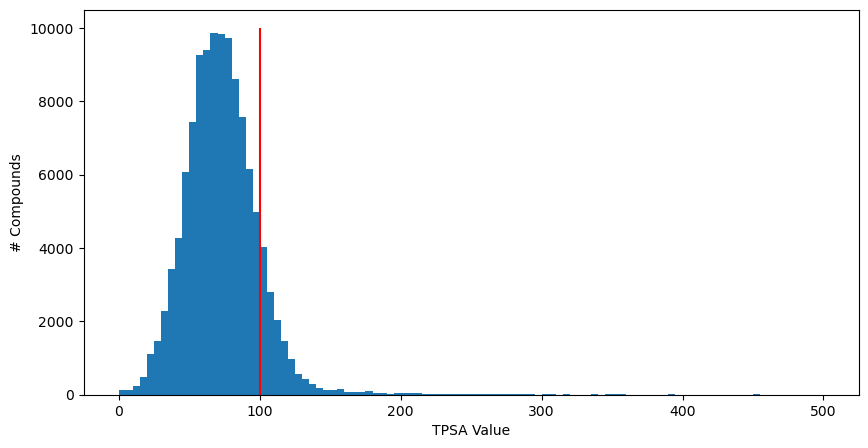

In [239]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

num_bins = 100
fig = plt.figure(figsize=(10,5))
# fig, ax = plt.subplots()
 
# the histogram of the data
n, bins, patches = plt.hist(df_metadata.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# We can set the number of bins with the *bins* keyword argument.
plt.xlabel('TPSA Value');
plt.ylabel('# Compounds');
plt.vlines(100,0,10000, colors='red')
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

### add Metadata_Permiation to df_TPSA

In [ ]:
# print(f" IN  - compound TPSA File                    : {compoundTPSACleanFile}")
# print(f" OUT - compound TPSA Clean File              : {compoundTPSACleanFile}\n")
# print()

In [4]:
# print(f"--> compound TPSA Clean File                 : {compoundTPSACleanFile}\n")
# df_tpsa = pd.read_csv(compoundTPSACleanFile)
# df_tpsa.info()
# df_tpsa.head(2)
# df_tpsa.tail(2)

In [34]:
# df_tpsa['TPSA'].std(),df_tpsa['TPSA'].mean()
# df_tpsa['lnTPSA'].std(),df_tpsa['lnTPSA'].mean()
# df_tpsa['log10TPSA'].std(),df_tpsa['log10TPSA'].mean()

In [5]:
# df_tpsa['permiation'] = 0
# df_tpsa.permiation[df_metadata.TPSA >= TPSA_THRESHOLD] = 1

# Add `Metadata_Hash` and `Metadata_Bin` Columns

In [240]:
print(ds.compoundMetadataTPSACleanFile)
NUMBER_OF_BINS = 16


./output_10162024/compound_metadata_tpsa_clean.csv


In [243]:
# df_metadata = pd.read_csv(ds.compoundMetadataTPSACleanFile)
df_metadata_clean.info()
df_metadata_clean.head(5)
df_metadata_clean.tail(5)
df_metadata_clean['Metadata_Permiation'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 116691 entries, 0 to 116750
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_InChIKey    116691 non-null  object 
 2   Metadata_InChI       116691 non-null  object 
 3   Metadata_Smiles      116691 non-null  object 
 4   Metadata_TPSA        116691 non-null  float64
 5   Metadata_lnTPSA      116691 non-null  float64
 6   Metadata_log10TPSA   116691 non-null  float64
 7   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 12.0+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation
116746,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216,1
116747,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645,0
116748,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116749,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116750,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


Metadata_Permiation
0    102417
1     14274
Name: count, dtype: int64

In [248]:
df_metadata_clean['Metadata_Hash'] = df_metadata_clean['Metadata_JCP2022'].map(hash)
df_metadata_clean['Metadata_Bin']  = df_metadata_clean['Metadata_Hash'].map(lambda x: mod(x,NUMBER_OF_BINS))

In [250]:
df_metadata_clean

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Metadata_Hash,Metadata_Bin
0,JCP2022_000001,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0,2440241975654110680,8
1,JCP2022_000002,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0,-870368651054634396,4
2,JCP2022_000003,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0,6218435319191466754,2
3,JCP2022_000004,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0,7887790091381819861,5
4,JCP2022_000005,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0,8593306527078855415,7
...,...,...,...,...,...,...,...,...,...,...
116746,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216,1,7078851567130000001,1
116747,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645,0,-1852856265090862307,13
116748,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0,3424852513362884069,5
116749,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0,8287878185965590908,12


In [262]:
df_metadata_clean.Metadata_JCP2022.dtype
df_metadata_clean.Metadata_Hash.dtype
_tmp = df_metadata_clean.loc[0, 'Metadata_JCP2022']
_tmp, type(_tmp), len(_tmp)
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)
_tmp = "JCP2022_000001"
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)
_tmp = "JCP2022_000002"
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)

dtype('O')

dtype('int64')

('JCP2022_000001', str, 14)

('JCP2022_000001', 2440241975654110680, int)

('JCP2022_000001', 2440241975654110680, int)

('JCP2022_000002', -870368651054634396, int)

In [253]:
for i in range(10):
    print(f" {df_metadata.loc[i].Metadata_Hash}    {df_metadata.loc[i].Metadata_Hash % NUMBER_OF_BINS} ")    

 2440241975654110680    8 
 -870368651054634396    4 
 6218435319191466754    2 
 7887790091381819861    5 
 8593306527078855415    7 
 8650584329207170141    13 
 2651672624543573766    6 
 205923168286492873    9 
 5576727983125806999    7 
 -7443320955088799461    11 


In [38]:
df_metadata.Metadata_Bin.value_counts().sort_index()

Metadata_Bin
0     9755
1     9507
2     9643
3     9781
4     9777
5     9763
6     9848
7     9752
8     9712
9     9693
10    9679
11    9781
Name: count, dtype: int64

# Rename and reorder columns

In [39]:
df_metadata.columns

Index(['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Smiles', 'Metadata_TPSA',
       'Metadata_lnTPSA', 'Metadata_logTPSA', 'Metadata_Permiation', 'Metadata_Bin'],
      dtype='object')

In [40]:
df_metadata.rename(columns ={ 'smiles': 'Metadata_Smiles', 
                              'TPSA'  : 'Metadata_TPSA', 
                              'lnTPSA': 'Metadata_lnTPSA', 
                              'log10TPSA' : 'Metadata_log10TPSA'}, inplace=True)

In [41]:
df_metadata.head(2)

,Metadata_JCP2022,Metadata_Hash,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation,Metadata_Bin
0,JCP2022_000001,-8640665944756343816,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0,4
1,JCP2022_000002,-2058530355611931119,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0,1


In [42]:
df_metadata.head(2)

,Metadata_JCP2022,Metadata_Hash,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation,Metadata_Bin
0,JCP2022_000001,-8640665944756343816,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0,4
1,JCP2022_000002,-2058530355611931119,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0,1


In [43]:
df_metadata = df_metadata[['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_Smiles', 'Metadata_TPSA', 'Metadata_lnTPSA',
       'Metadata_logTPSA', 'Metadata_Permiation', ]]

In [44]:
df_metadata

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
0,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
2,JCP2022_000003,8228137599824226564,0,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0
3,JCP2022_000004,2222818783381135156,4,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
4,JCP2022_000005,-5338746385487734035,9,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0
...,...,...,...,...,...,...,...,...,...,...
116686,JCP2022_116749,-2319171568672221400,8,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216,1
116687,JCP2022_116750,9161564570943414536,8,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645,0
116688,JCP2022_116751,5024933905542715644,0,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116689,JCP2022_116752,8043583690001075349,9,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0


## Write `df_metadata` and `df_tpsa` to output files

### Write `compoundMetadataTPSACleanFile`

In [ ]:
print(f" OUTPUT - compound Metadata + TPSA Cleaned File : {compoundMetadataTPSACleanFile}")
print(f" --> compound Metadata + TPSA Cleaned File      : {compoundMetadataTPSACleanFile}\n")

In [55]:
df_metadata.to_csv(compoundMetadataTPSACleanFile, index = False)

### write `compoundTPSACleanFile`

In [56]:
print(f" OUTPUT - compound TPSA Clean File              : {compoundTPSACleanFile}\n")

--> compound TPSA Clean File                 : ./output_11102023/compound_TPSA_clean.csv



In [58]:
df_tpsa.to_csv(compoundTPSACleanFile, index = False, columns=['JCP2022', 'TPSA', 'permiation'])

In [72]:
# del df_tpsa
# del df_metadata
# del df_nans,
# del df_smiles
# del df_tpsa_zero
# del df_tpsa_nan
# del df_tpsa_inv
# del df_md_zero
# del df_md_nan
# del df_md_inv
# del df

## check the files we just wrote 


### `compoundMetadataTPSACleanFile`

In [8]:
print(compoundMetadataTPSACleanFile)

./output_11102023/compound_metadata_tpsa_clean.csv


In [9]:
df_metadata = pd.read_csv(compoundMetadataTPSACleanFile)
df_metadata.info()
# df_metadata.head(5)
df_metadata.tail(5)
df_metadata.permiation.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Metadata_JCP2022   116691 non-null  object 
 1   Metadata_InChIKey  116691 non-null  object 
 2   Metadata_InChI     116691 non-null  object 
 3   smiles             116691 non-null  object 
 4   TPSA               116691 non-null  float64
 5   lnTPSA             116691 non-null  float64
 6   log10TPSA          116691 non-null  float64
 7   permiation         116691 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ MB


,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,smiles,TPSA,lnTPSA,log10TPSA,permiation
116686,JCP2022_116749,ZZZRUAITSXLWBH-UHFFFAOYSA-N,InChI=1S/C23H27N3O7/c1-25(2)12-5-6-13(27)15-10...,CN(C)C3C(=O)C(C(=N)O)C(=O)C4(O)C(=O)C2C(=O)c1c...,159.30,5.070789,2.202216,1
116687,JCP2022_116750,ZZZTXDPKNAOZPM-UHFFFAOYSA-N,InChI=1S/C22H27N3O2/c1-14-18(22(27)24-15(2)23-...,Cc4nc(C)c(CCC(=O)N(C1CC1)C2CCCc3ccccc23)c(O)n4,66.32,4.194492,1.821645,0
116688,JCP2022_116751,ZZZUOLMMTJKOGE-UHFFFAOYSA-N,InChI=1S/C19H17N5O2/c1-23-9-6-13-7-10-24(19(26...,CN4C=CC3C=CN(CCN=C(O)c2cnc1ccccc1n2)C(=O)C=34,85.30,4.446174,1.930949,0
116689,JCP2022_116752,ZZZZIBSVRUABIA-UHFFFAOYSA-N,InChI=1S/C19H13F6N3O2S/c1-11-26-6-5-17(27-11)1...,Cc1nccc(n1)c2cccc(c2)NS(=O)(=O)c3cc(cc(c3)C(F)...,71.95,4.275971,1.857031,0
116690,JCP2022_116753,ZZZZVNLQWWXZTQ-UHFFFAOYSA-N,InChI=1S/C14H20N2O3/c1-18-13-5-3-2-4-12(13)14(...,COc1ccccc1C(O)=NCCN2CCOCC2,54.29,3.994340,1.734720,0


permiation
0    102417
1     14274
Name: count, dtype: int64

### `compoundTPSACleanFile`

In [7]:
# print(compoundTPSACleanFile)

./output_11102023/compound_TPSA_clean.csv


In [6]:
# df_tpsa = pd.read_csv(compoundTPSACleanFile)
# df_tpsa.info()
# df_tpsa.head()
# df_tpsa.tail()
# df_tpsa.permiation.value_counts()